In [31]:
from vivarium import Artifact
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from db_queries import get_ids, get_outputs
import scipy.stats

!whoami
!date

alibow
Tue Mar 31 13:10:49 PDT 2020


# 1. Exploring the output and doing spot-check validation on the intervention results

This notebook was copied and modified from Ali's notebook `model_5_vitamin_a_outputs` on 3/30/2020.

In [32]:
output_dirs = ['/ihme/costeffectiveness/results/vivarium_conic_lsff/v4.0_folic_acid_fortification/ethiopia/2020_03_18_23_04_26/count_data/',
               '/ihme/costeffectiveness/results/vivarium_conic_lsff/v4.0_folic_acid_fortification/india/2020_03_18_23_04_36/count_data/',
              '/ihme/costeffectiveness/results/vivarium_conic_lsff/v4.0_folic_acid_fortification/nigeria/2020_03_18_23_04_42/count_data/']

locations = ['Ethiopia','India','Nigeria']

In [33]:
index_cols = ['year', 'age_group', 'sex', 'cause', 'fortification_group',
        'input_draw', 'scenario']

In [34]:
# load and merge stratified count results for each location, outcome
master_counts = pd.DataFrame()
master_rates = pd.DataFrame()
for i in range(len(output_dirs)):
    yll_count = pd.read_hdf(output_dirs[i] + 'ylls.hdf').rename(
        columns={'value':'ylls'}).drop(columns='measure')
    yld_count = pd.read_hdf(output_dirs[i] + 'ylds.hdf').rename(
        columns={'value':'ylds'}).drop(columns='measure')
    daly_count = yll_count.merge(yld_count, right_on=index_cols, left_on=index_cols)
    daly_count['dalys'] = daly_count['ylls'] + daly_count['ylds']
    deaths = pd.read_hdf(output_dirs[i] + 'deaths.hdf').rename(
        columns={'value':'deaths'}).drop(columns='measure')
    data = daly_count.merge(deaths, right_on=index_cols, left_on=index_cols)
    person_time = pd.read_hdf(output_dirs[i] + 'person_time.hdf').rename(
        columns={'value':'person_time'}).drop(columns='measure')
    counts = data.merge(person_time,
                        right_on=['year', 'age_group', 'sex',
                                  'fortification_group',
                                  'input_draw', 'scenario'],
                        left_on=['year', 'age_group', 'sex', 
                                 'fortification_group',
                                 'input_draw', 'scenario'])
    counts['location'] = locations[i]
    master_counts = master_counts.append(counts)
master_counts.head()

,year,age_group,sex,cause,fortification_group,input_draw,scenario,ylls,ylds,dalys,deaths,person_time,location
0,2020,1_to_4,female,diarrheal_diseases,false,21,baseline,0.0,0.0,0.0,0.0,0.0,Ethiopia
1,2020,1_to_4,female,lower_respiratory_infections,false,21,baseline,0.0,0.0,0.0,0.0,0.0,Ethiopia
2,2020,1_to_4,female,measles,false,21,baseline,0.0,0.0,0.0,0.0,0.0,Ethiopia
3,2020,1_to_4,female,neural_tube_defects,false,21,baseline,0.0,0.0,0.0,0.0,0.0,Ethiopia
4,2020,1_to_4,female,diarrheal_diseases,false,21,folic_acid_fortification_scale_up,0.0,0.0,0.0,0.0,0.0,Ethiopia


In [66]:
counts_first_year = master_counts.where(master_counts['age_group'] != '1_to_4').dropna()
counts_first_year.head()

,year,age_group,sex,cause,fortification_group,input_draw,scenario,ylls,ylds,dalys,deaths,person_time,location
1200,2020,early_neonatal,female,diarrheal_diseases,false,21.0,baseline,175.754172,1.099575,176.853747,2.0,402.471131,Ethiopia
1201,2020,early_neonatal,female,lower_respiratory_infections,false,21.0,baseline,87.877086,0.019731,87.896817,1.0,402.471131,Ethiopia
1202,2020,early_neonatal,female,measles,false,21.0,baseline,0.000000,0.000000,0.000000,0.0,402.471131,Ethiopia
1203,2020,early_neonatal,female,neural_tube_defects,false,21.0,baseline,615.174746,0.124577,615.299323,7.0,402.471131,Ethiopia
1204,2020,early_neonatal,female,diarrheal_diseases,false,21.0,folic_acid_fortification_scale_up,175.754172,1.045089,176.799261,2.0,385.013998,Ethiopia


In [119]:
# define function to calculate averted outcomes (dalys, ylds, ylls, deaths) in rate space
# by specified stratifying variables

def get_stratified_averted_results(dataset, strata_cols):  
    data = pd.DataFrame.copy(dataset)
    overall = data.groupby((['location','scenario','input_draw']+strata_cols), as_index=False).sum()
    overall_rates = pd.DataFrame.copy(overall)
    for measure in ['ylls','ylds','dalys','deaths','person_time']:
            overall_rates[measure] = overall_rates[measure] / overall_rates['person_time'] * 100_000
    overall_baseline = (overall_rates.where(overall_rates['scenario'] == 'baseline').dropna()
                        .set_index((['location','input_draw']+strata_cols)).drop(columns='scenario'))
    overall_intervention = (overall_rates.where(overall_rates['scenario'] == 'folic_acid_fortification_scale_up').dropna()
                            .set_index((['location','input_draw']+strata_cols)).drop(columns='scenario'))
    merged = overall_baseline.merge(overall_intervention, right_on=(['location','input_draw']+strata_cols),
                                    left_on=(['location','input_draw']+strata_cols), 
                                    suffixes=('_baseline','_intervention'))
    # drop rows where there is zero person time in either the baseline or intervention
    merged = merged.where(merged['person_time_intervention'] != 0).where(merged['person_time_baseline'] != 0).dropna()
    for measure in ['ylls','ylds','dalys','deaths']:
        merged[f'{measure}'] = merged[f'{measure}_baseline'] - merged[f'{measure}_intervention'] 
    merged = (merged.reset_index().groupby((['location']+strata_cols))
                       .describe(percentiles=[0.025,0.975,0.25,0.75]))
    return merged

In [108]:
overall_results = get_stratified_averted_results(master_counts, [])
overall_by_year = get_stratified_averted_results(master_counts, ['year'])
first_year_overall = get_stratified_averted_results(counts_first_year, [])
first_year_by_year = get_stratified_averted_results(counts_first_year, ['year'])

In [109]:
def make_plots_by_year(dataset, outcome_var, age_description):
    if outcome_var == 'dalys':
        outcome_name_long = 'Disability Adjusted Life Years (DALYs)'
        outcome_name_short = 'DALYs'
    elif outcome_var == 'ylls':
        outcome_name_long = 'Years of Life Lost (YLLs)'
        outcome_name_short = 'YLLs'
    elif outcome_var == 'ylds':
        outcome_name_long = 'Years Lived with Disability (YLDs)'
        outcome_name_short = 'YLDs'
    else:
        outcome_name_long = 'Deaths'
        outcome_name_short = 'Deaths'
        
    data = dataset.reset_index()
    
    ethiopia = data.where(data['location'] == 'Ethiopia').dropna()
    india = data.where(data['location'] == 'India').dropna()
    nigeria = data.where(data['location'] == 'Nigeria').dropna()

    plt.scatter(ethiopia['year'], ethiopia[outcome_var,'mean'])
    plt.plot(ethiopia['year'], ethiopia[outcome_var,'mean'])

    plt.scatter(india['year'], india[outcome_var,'mean'])
    plt.plot(india['year'], india[outcome_var,'mean'])

    plt.scatter(nigeria['year'], nigeria[outcome_var,'mean'])
    plt.plot(nigeria['year'], nigeria[outcome_var,'mean'])

    plt.title(f'{outcome_name_short} Averted per 100,000 Person-Years in the ' + age_description + ' of Life')
    plt.legend(['Ethiopia','India','Nigeria'])
    plt.ylabel(f'{outcome_name_short} Averted per 100,000 PY')
    # plt.savefig('ethiopia_and_nigeria_by_year.png')

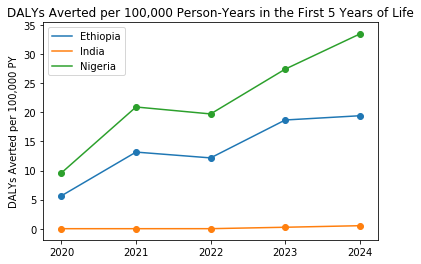

In [110]:
make_plots_by_year(overall_by_year,'dalys', 'First 5 Years')

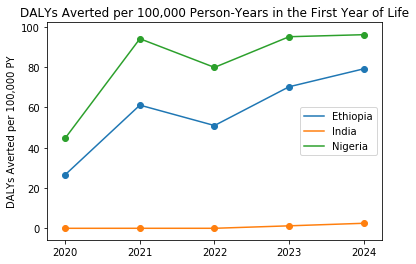

In [111]:
make_plots_by_year(first_year_by_year,'dalys', 'First Year')

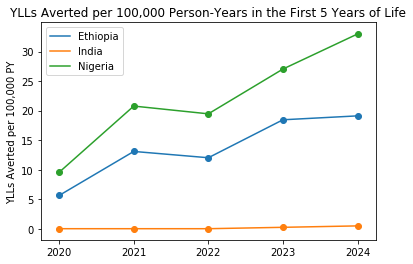

In [112]:
make_plots_by_year(overall_by_year,'ylls', 'First 5 Years')

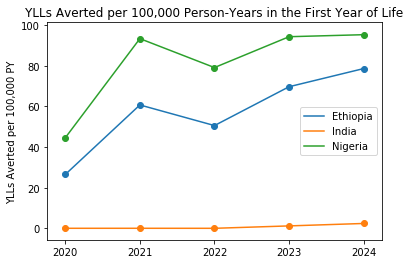

In [113]:
make_plots_by_year(first_year_by_year,'ylls', 'First Year')

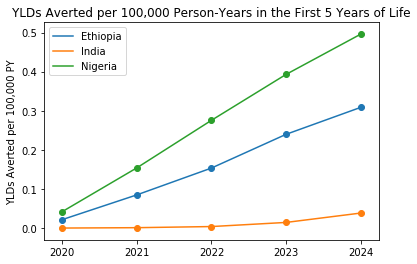

In [114]:
make_plots_by_year(overall_by_year,'ylds', 'First 5 Years')

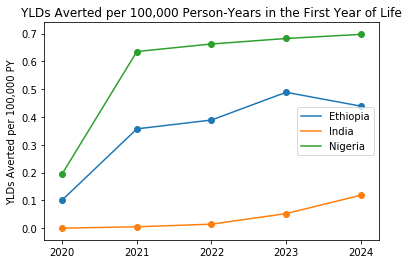

In [115]:
make_plots_by_year(first_year_by_year,'ylds', 'First Year')

In [116]:
# define plotting function for overall, non-stratified results
# NOTE: spacing will need to be edited when India results are completed

def make_dot_plots(dataset, outcome_var, age_description):
    data = pd.DataFrame.copy(dataset) 
    
    if outcome_var == 'dalys':
        outcome_name_long = 'Disability Adjusted Life Years (DALYs)'
        outcome_name_short = 'DALYs'
    elif outcome_var == 'ylls':
        outcome_name_long = 'Years of Life Lost (YLLs)'
        outcome_name_short = 'YLLs'
    elif outcome_var == 'ylds':
        outcome_name_long = 'Years Lived with Disability (YLDs)'
        outcome_name_short = 'YLDs'
    else:
        outcome_name_long = 'Deaths'
        outcome_name_short = 'Deaths'
        
        
    plt.plot([0.1,0.7],[0,0],'--',c='grey')

    plt.plot([0.2,0.2],[data[outcome_var,'min'][0],data[outcome_var,'max'][0]],c='black')
    plt.plot([0.4,0.4],[data[outcome_var,'min'][1],data[outcome_var,'max'][1]],c='black')
    plt.plot([0.6,0.6],[data[outcome_var,'min'][2],data[outcome_var,'max'][2]],c='black')
    
    plt.scatter([0.2,0.4,0.6],data[outcome_var,'min'], marker='_',c='black',s=50)
    plt.scatter([0.2,0.4,0.6],data[outcome_var,'max'], marker='_',c='black',s=50)

    plt.scatter([0.2,0.4,0.6],data[outcome_var,'mean'], s=100)

    plt.xticks([0.2,0.4,0.6], data.index)
    
    plt.title(f'{outcome_name_short} Averted per 100,000 Person-Years in the ' + age_description + ' of Life')
    plt.ylabel(f'{outcome_name_short} Averted per 100,000 PY')

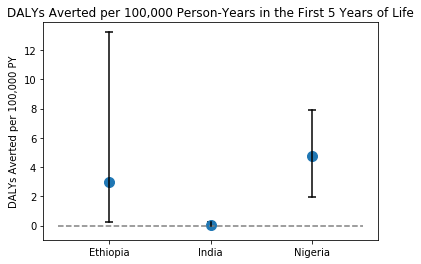

In [117]:
make_dot_plots(overall_results, 'dalys', 'First 5 Years')

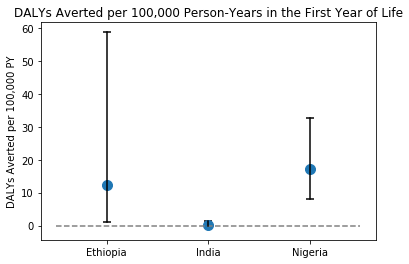

In [118]:
make_dot_plots(first_year_overall, 'dalys', 'First Year')

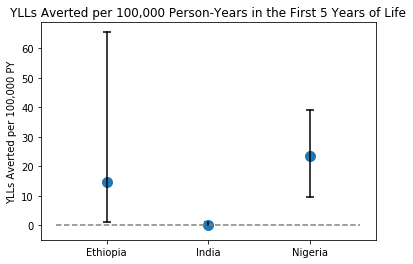

In [93]:
make_dot_plots(overall_results, 'ylls', 'First 5 Years')

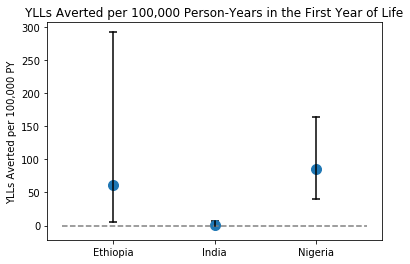

In [94]:
make_dot_plots(first_year_overall, 'ylls', 'First Year')

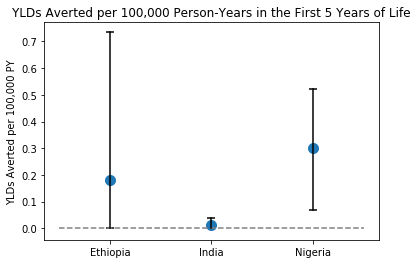

In [95]:
make_dot_plots(overall_results, 'ylds', 'First 5 Years')

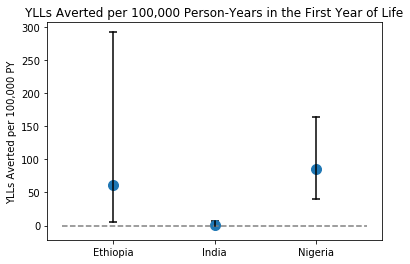

In [96]:
make_dot_plots(first_year_overall, 'ylls', 'First Year')

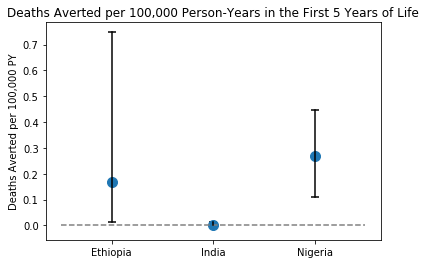

In [97]:
make_dot_plots(overall_results, 'deaths', 'First 5 Years')

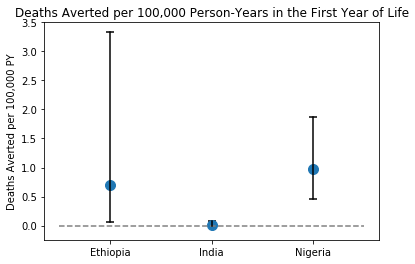

In [98]:
make_dot_plots(first_year_overall, 'deaths', 'First Year')